In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import copy
import datetime
import json
import meshio
import os
import warnings
import scipy
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from pprint import pprint
from ismember import ismember
import colorcet as cc
import matplotlib
import skies


In [3]:
FONTSIZE = 12


In [4]:
run_name = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
base_runs_folder = "./runs/"
output_path = os.path.join(base_runs_folder, run_name)
mesh_parameters_file_name = "./data/nankai_mesh_parameters.json"
skies.create_output_folder(base_runs_folder, output_path)
meshes = skies.read_meshes(mesh_parameters_file_name)


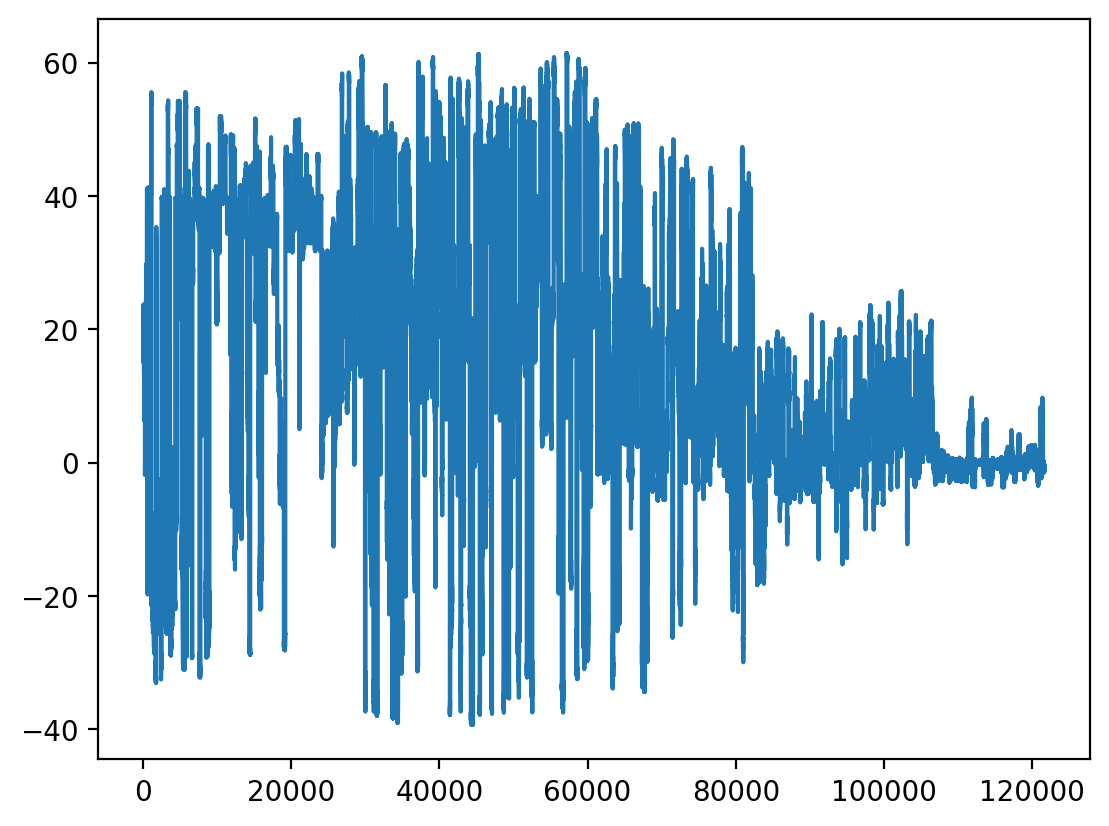

In [5]:
# Set initial conditions with accumulated slip
sources = addict.Dict()
sources.lon = np.array([235.779])
sources.lat = np.array([45.553])
sources.magnitude = np.array([10.0])
sources.slip_type = ["dip_slip"]
initial_slip_deficit = skies.get_synthetic_accumulated_slip(meshes[0], sources)
# initial_dip_slip_deficit = initial_slip_deficit[1::2]
initial_dip_slip_deficit = np.load("./data/nankai_high_resolution_tde_dip_slip_rates.npy")
total_coseismic_slip = np.zeros_like(initial_dip_slip_deficit)
plt.plot(initial_dip_slip_deficit)

In [6]:
KM2_TO_M2 = 1e6  # kilometers squared to meters squared


def plot_event_clean(
    event,
    meshes,
    pre_event_slip_deficit,
    probability,
    post_event_slip_deficit,
    t,
    iteration_step,
):
    # Plot distances from current event hypocenter triangle
    plt.figure(figsize=(15, 5))

    # Plot pre-earthquake slip deficit
    plt.subplot(1, 3, 1)
    pc = skies.plot_meshes(meshes, pre_event_slip_deficit, plt.gca(), "magma_r")
    plt.colorbar(pc, label="initial slip deficit (m)")
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
    plt.title(f"pre-earthquake slip deficit")

    # Plot slip distribution
    plt.subplot(1, 3, 2)
    fill_value = np.zeros(meshes[0].n_tde)
    fill_value[event.triangle_index] = event.slip
    x_coords = meshes[0].meshio_object.points[:, 0]
    y_coords = meshes[0].meshio_object.points[:, 1]
    vertex_array = np.asarray(meshes[0].verts)
    ax = plt.gca()
    xy = np.c_[x_coords, y_coords]
    verts = xy[vertex_array]
    pc = matplotlib.collections.PolyCollection(
        verts,
        edgecolor=None,
        cmap="gnuplot2_r",
        linewidth=0,
        alpha=1.0,
    )
    pc.set_array(fill_value)
    ax.add_collection(pc)
    ax.autoscale()
    plt.gca().set_aspect("equal")
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
    plt.colorbar(pc, label="slip (m)")
    plt.title(f"M = {event.moment_magnitude[0]:0.3}")

    plt.subplot(1, 3, 3)
    pc = skies.plot_meshes(meshes, post_event_slip_deficit, plt.gca(), "magma_r")
    plt.colorbar(pc, label="slip deficit (m)")
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
    plt.title(f"post-earthquake slip deficit")

    # plt.suptitle(f"{iteration_step=}, {t=}")
    plt.show()


def inpolygon(xq, yq, xv, yv):
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = matplotlib.path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)


# def rbf_interpolate(fill_value):
#     # Observation coordinates and data
#     x_vec = np.linspace(231, 239, N_GRID_X)
#     y_vec = np.linspace(38, 52, N_GRID_Y)
#     x_mat, y_mat = np.meshgrid(x_vec, y_vec)
#     y_mat = y_mat
#     centroids_lon = meshes[0].centroids[:, 0]
#     centroids_lat = meshes[0].centroids[:, 1]
#     centroids_val = fill_value

#     # Package for RBFInterpolator
#     xgrid = np.stack((x_mat, y_mat))
#     xflat = xgrid.reshape(2, -1).T
#     xobs = np.vstack((centroids_lon, centroids_lat)).T
#     yobs = centroids_val
#     yflat = scipy.interpolate.RBFInterpolator(
#         xobs, yobs, kernel="cubic", smoothing=0.01, epsilon=1.5
#     )(xflat)
#     ygrid = yflat.reshape(N_GRID_X, N_GRID_Y)
#     return xgrid, ygrid


def rbf_interpolate2(fill_value):
    # Observation coordinates and data
    # params.min_longitude = 130.0
    # params.max_longitude = 140.0
    # params.min_latitude = 30.0
    # params.max_latitude = 37.0
    x_vec = np.linspace(130, 140, N_GRID_X)
    y_vec = np.linspace(30, 37, N_GRID_Y)
    x_mat, y_mat = np.meshgrid(x_vec, y_vec)
    y_mat = y_mat
    centroids_lon = meshes[0].centroids[:, 0]
    centroids_lat = meshes[0].centroids[:, 1]
    centroids_val = fill_value

    # Package for RBFInterpolator
    xgrid = np.stack((x_mat, y_mat))
    xflat = xgrid.reshape(2, -1).T
    xobs = np.vstack((centroids_lon, centroids_lat)).T
    yobs = centroids_val
    # yflat = scipy.interpolate.RBFInterpolator(
    #     xobs, yobs, kernel="cubic", smoothing=0.01, epsilon=1.5
    # )(xflat)

    yflat = scipy.interpolate.RBFInterpolator(
        xobs, yobs, kernel="cubic", smoothing=0.00, epsilon=1.0
    )(xflat)
    ygrid = yflat.reshape(N_GRID_X, N_GRID_Y)
    return xgrid, ygrid


<Figure size 1200x600 with 0 Axes>

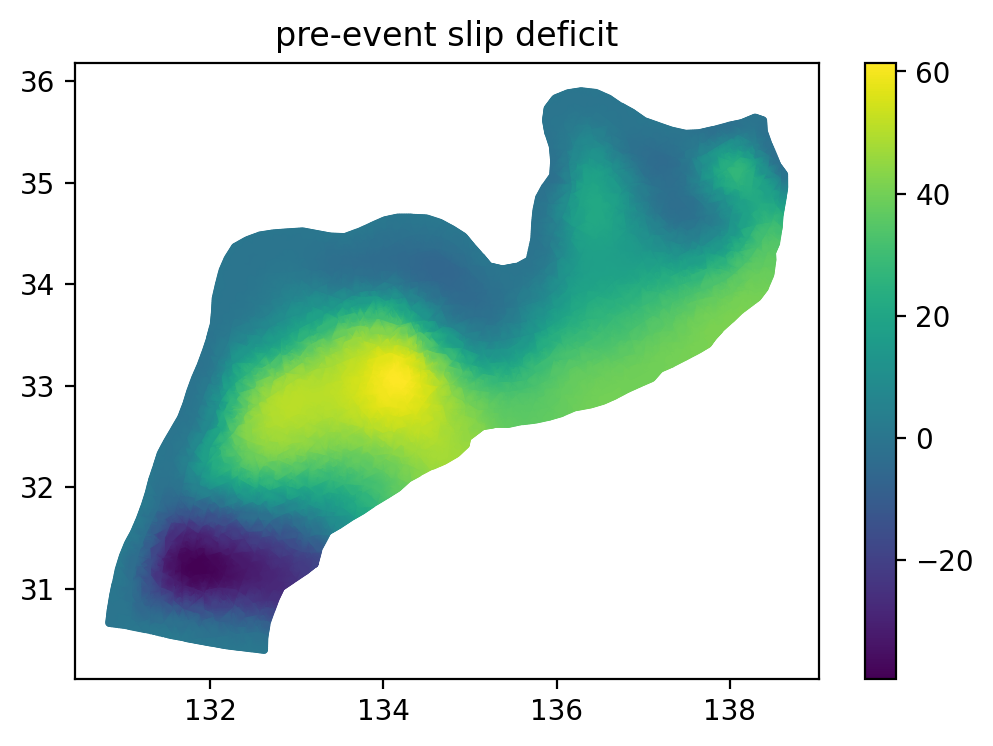

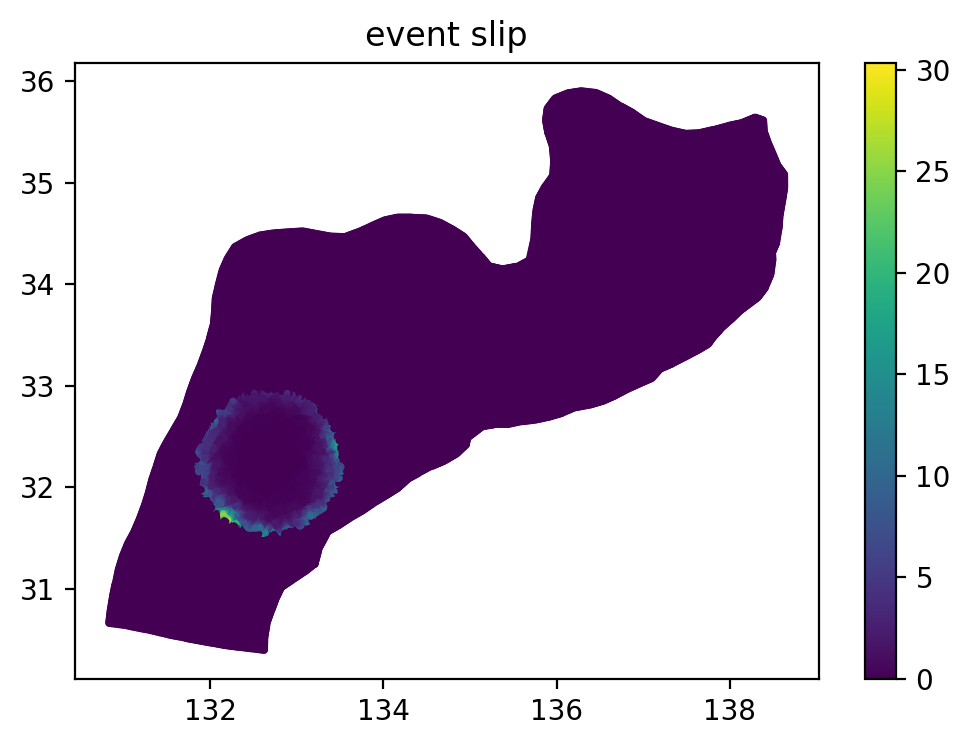

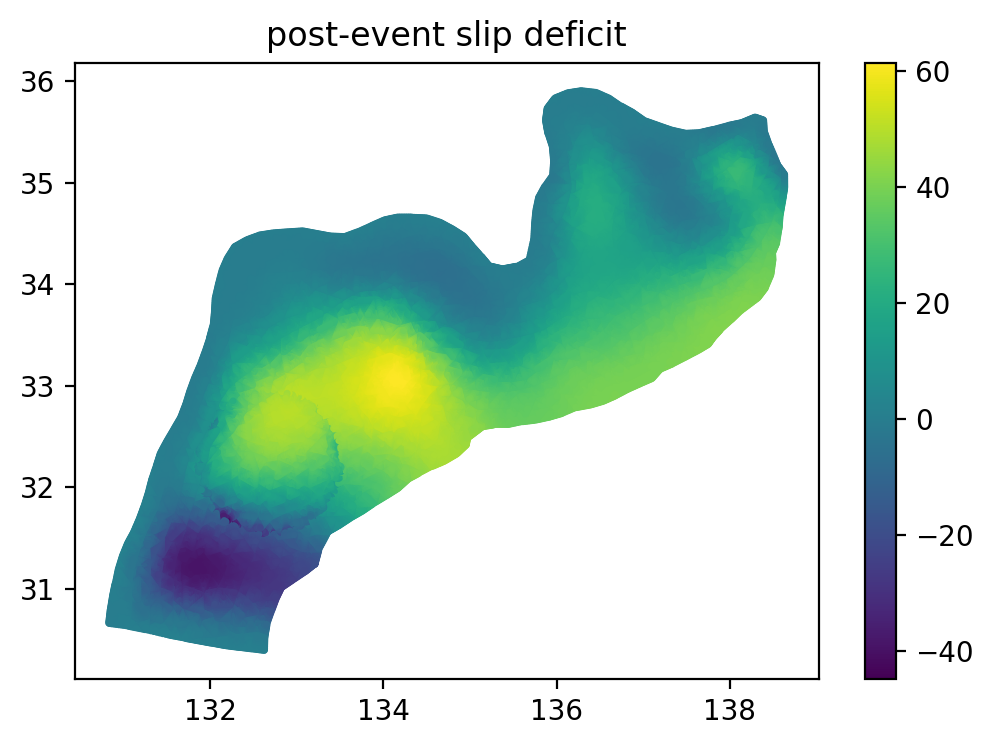

In [7]:
def plot_meshes(meshes, fill_value, ax):
    for i in range(len(meshes)):
        x_coords = meshes[i].meshio_object.points[:, 0]
        y_coords = meshes[i].meshio_object.points[:, 1]
        vertex_array = np.asarray(meshes[i].verts)

        if not ax:
            ax = plt.gca()
        xy = np.c_[x_coords, y_coords]
        verts = xy[vertex_array]
        pc = matplotlib.collections.PolyCollection(
            verts,
            edgecolor="k",
            cmap="plasma",
            linewidth=0.1,
            alpha=1.0,
        )
        pc.set_array(fill_value)
        ax.add_collection(pc)
        ax.autoscale()
        plt.gca().set_aspect("equal", adjustable="box")
        return pc

t = 0
N_GRID_X = 500
N_GRID_Y = 500
# plt.plot(initial_slip_deficit)
pre_event_slip_deficit = initial_dip_slip_deficit

plt.figure(figsize=(12, 6))
for i in range(1):

    # Only go through the event generation process of there is positive slip deficit somewhere
    if 1 > 0:
        # Generate event
        location_probability = skies.get_location_probability(pre_event_slip_deficit)
        event = skies.create_event(meshes, location_probability)
        total_coseismic_slip += event.slip_all_elements
        post_event_slip_deficit = pre_event_slip_deficit - event.slip_all_elements

        # Mesh plots
        plt.figure(figsize=(6, 4))
        plt.scatter(meshes[0].centroids[:, 0], meshes[0].centroids[:, 1], c=pre_event_slip_deficit, s=2)
        plt.colorbar()
        plt.title("pre-event slip deficit")
        plt.show()

        plt.figure(figsize=(6, 4))
        plt.scatter(meshes[0].centroids[:, 0], meshes[0].centroids[:, 1], c=event.slip_all_elements, s=2)
        plt.colorbar()

        # pc = plot_meshes(meshes, event.slip_all_elements, plt.gca())
        plt.title("event slip")
        plt.show()

        plt.figure(figsize=(6, 4))
        plt.scatter(meshes[0].centroids[:, 0], meshes[0].centroids[:, 1], c=post_event_slip_deficit, s=2)
        plt.colorbar()
        plt.title("post-event slip deficit")
        plt.show()



In [12]:
event.hypocenter_longitude = 134.0
event.hypocenter_latitude = 32.5
event.hypocenter_depth = 10.0
event.moment_magnitude = 8.0
event.shear_modulus = 3e10
event.area_scaling = 1.2

event = skies.get_event_area_slip_hypocenter(meshes[0], event)

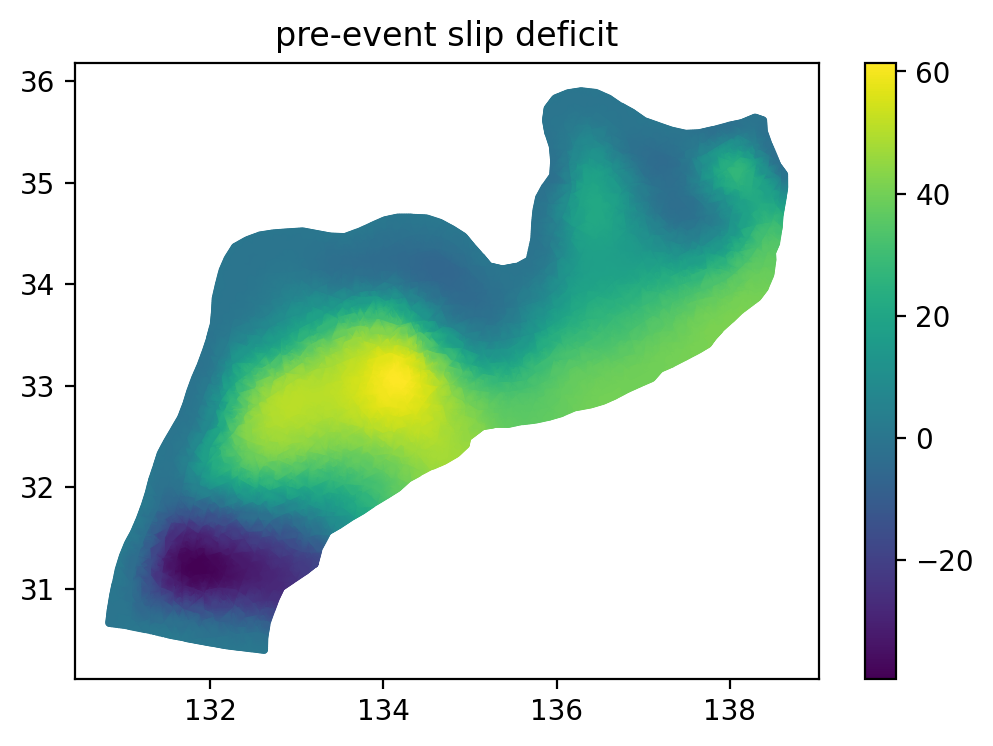

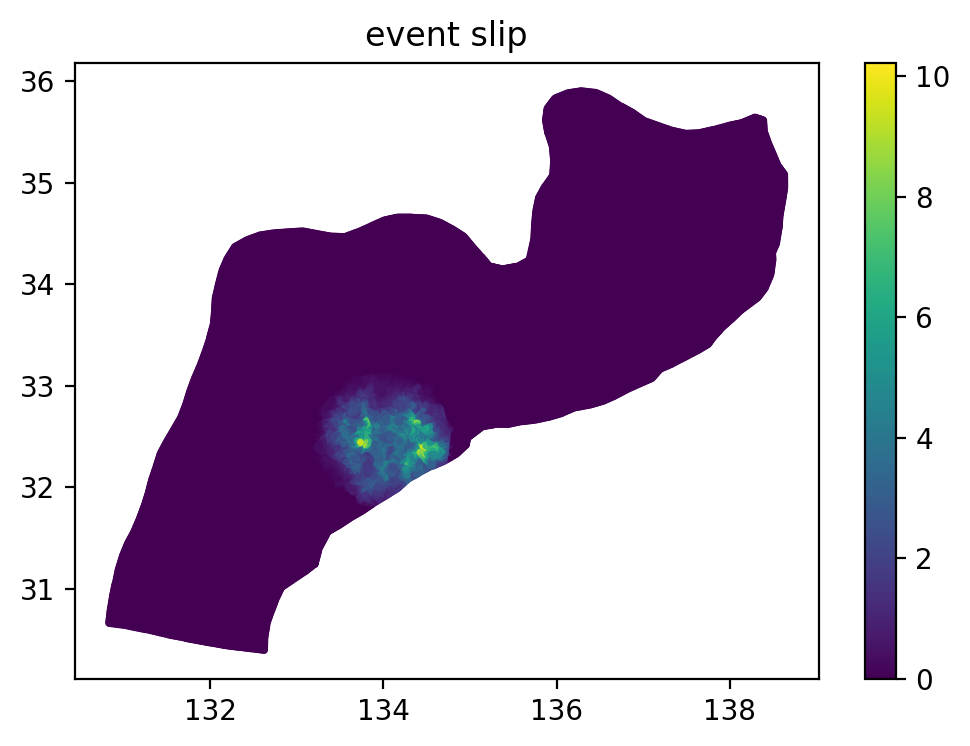

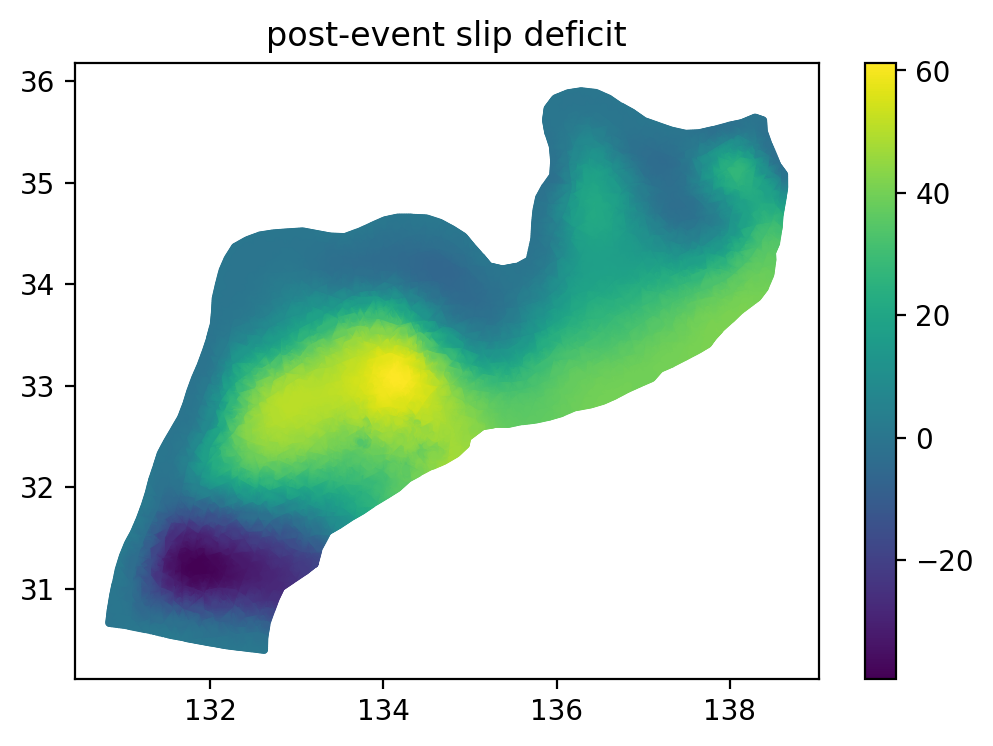

In [14]:
plt.figure(figsize=(6, 4))
plt.scatter(
    meshes[0].centroids[:, 0], meshes[0].centroids[:, 1], c=pre_event_slip_deficit, s=2
)
plt.colorbar()
plt.title("pre-event slip deficit")
plt.show()


plt.figure(figsize=(6, 4))
plt.scatter(
    meshes[0].centroids[:, 0], meshes[0].centroids[:, 1], c=event.slip_all_elements, s=2
)
plt.colorbar()
plt.title("event slip")
plt.show()


post_event_slip_deficit = pre_event_slip_deficit - event.slip_all_elements

plt.figure(figsize=(6, 4))
plt.scatter(
    meshes[0].centroids[:, 0], meshes[0].centroids[:, 1], c=post_event_slip_deficit, s=2
)
plt.colorbar()
plt.title("post-event slip deficit")
plt.show()
